In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [2]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [3]:
# pretty-print first element
print(json.dumps(annotations['like']['00bea9e7-add1-4cc3-b4bc-bcf234966a77'], indent=2))

{
  "bboxes": [
    [
      0.34258039,
      0.27383551,
      0.11112897,
      0.12042015
    ],
    [
      0.69848283,
      0.6396801,
      0.06343015,
      0.13032828
    ]
  ],
  "labels": [
    "like",
    "no_gesture"
  ],
  "landmarks": [
    [
      [
        0.3584672712074522,
        0.3571339641382124
      ],
      [
        0.36732797155189495,
        0.33441325004832606
      ],
      [
        0.38145247076662214,
        0.31495838376387414
      ],
      [
        0.3918127748102413,
        0.29798641451915764
      ],
      [
        0.3954751298501279,
        0.28278310668576623
      ],
      [
        0.4250498146344702,
        0.33466009625076915
      ],
      [
        0.4437871809228524,
        0.34533088368572257
      ],
      [
        0.434208268431514,
        0.3477299423053817
      ],
      [
        0.42248493458037467,
        0.3452949077584035
      ],
      [
        0.42570372893646796,
        0.35057689563961686
      ],
      [
    

## helper function to pre-process images (color channel conversion and resizing)

In [4]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

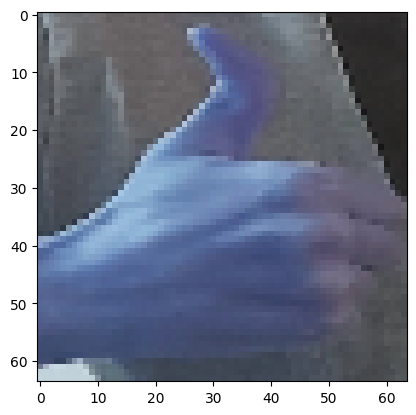

In [6]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [8]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [10]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'relu'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [11]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4171 - loss: 1.0544 - val_accuracy: 0.4219 - val_loss: 1.0601 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4076 - loss: 1.0522 - val_accuracy: 0.5234 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5162 - loss: 0.9882 - val_accuracy: 0.7109 - val_loss: 0.7276 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7178 - loss: 0.7147 - val_accuracy: 0.7344 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7647 - loss: 0.5985 - val_accuracy: 0.9062 - val_loss: 0.3857 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8714 - loss: 0.3841 - val_accuracy: 0.9062 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8827 - loss: 0.3602 - val_acc

In [12]:
# let's have a look at our model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

## Plot accuracy and loss of the training process

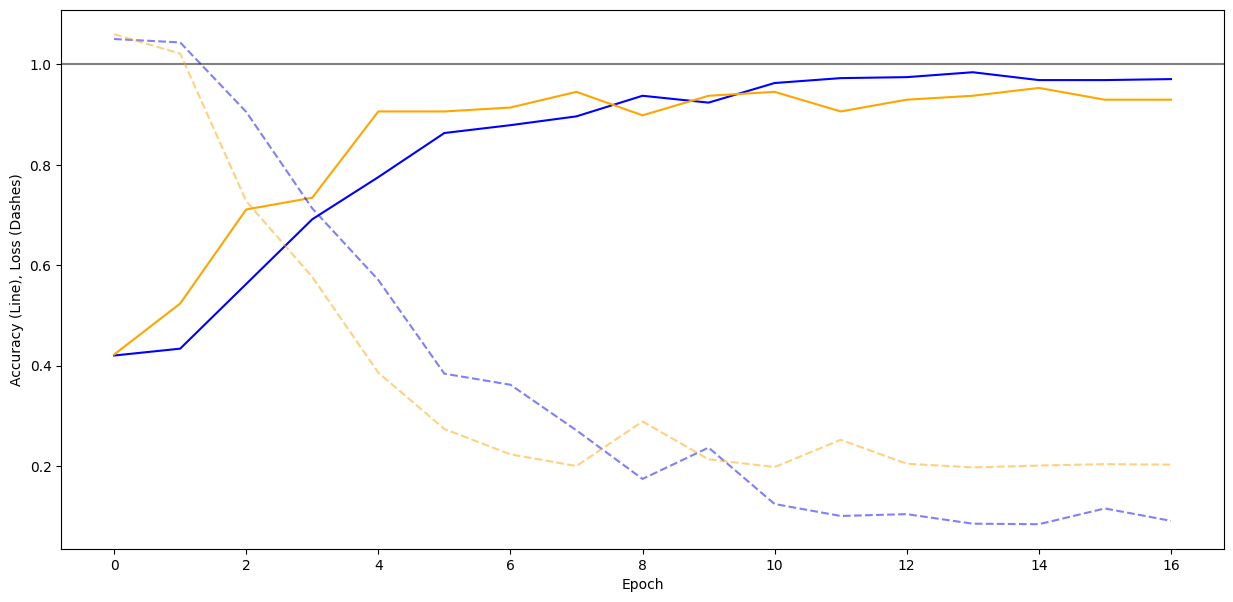

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [ ]:
model.save('gesture_recognition')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
before [[1.6277428e-01 6.5929425e-04 8.3656645e-01]
 [9.9910092e-01 8.3183276e-04 6.7236884e-05]
 [9.8768717e-01 2.1946675e-03 1.0118171e-02]
 [1.5567632e-04 9.2988757e-06 9.9983501e-01]
 [9.9812597e-01 1.1931901e-03 6.8086985e-04]
 [9.9999797e-01 2.0055909e-06 1.3206845e-08]
 [9.9736857e-01 2.5223472e-04 2.3791746e-03]
 [1.6562128e-01 8.3313543e-01 1.2433094e-03]
 [9.9887842e-01 4.2060381e-04 7.0100906e-04]
 [9.9126643e-01 3.5771828e-03 5.1563731e-03]
 [9.4829779e-04 3.6256691e-04 9.9868923e-01]
 [2.3179795e-03 9.9304777e-01 4.6343007e-03]
 [7.5635326e-01 2.0385358e-01 3.9793242e-02]
 [7.4251229e-03 6.1446457e-04 9.9196047e-01]
 [9.9998105e-01 1.8533385e-05 5.0154659e-07]
 [5.4335180e-03 1.6292831e-02 9.7827357e-01]
 [1.2276550e-05 9.9996448e-01 2.3226676e-05]
 [9.5199823e-05 1.2563860e-04 9.9977916e-01]
 [2.5010735e-03 9.9412233e-01 3.3765680e-03]
 [6.6020526e-04 6.5809050e-05 9.9927408e-01]
 [1.4175662e-01 8.2731879e-01 3.0924564e-02]
 [2.086485

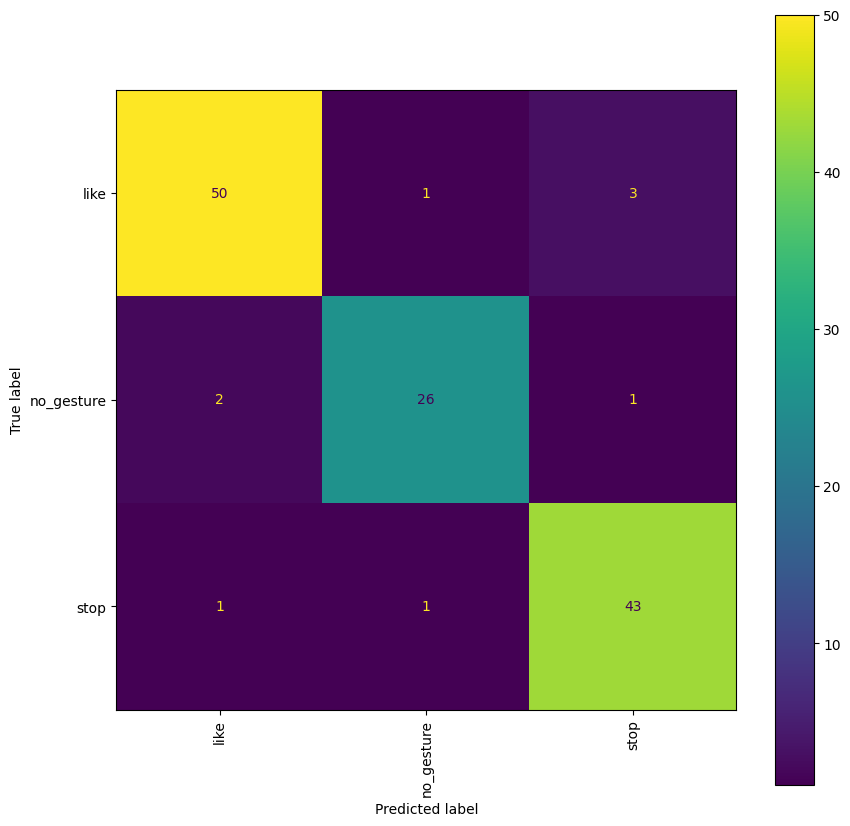

In [14]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

Version 1:
relu


Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4100 - loss: 1.0969 - val_accuracy: 0.3516 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4423 - loss: 1.0391 - val_accuracy: 0.4688 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5672 - loss: 0.9716 - val_accuracy: 0.6172 - val_loss: 0.8285 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6807 - loss: 0.7436 - val_accuracy: 0.7578 - val_loss: 0.5629 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8407 - loss: 0.4834 - val_accuracy: 0.8828 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8722 - loss: 0.3758 - val_accuracy: 0.8750 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8611 - loss: 0.3765 - val_accuracy: 0.89

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_8 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_8               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
before [[0.13572873 0.00699487 0.8572764 ]
 [0.99081707 0.00579701 0.00338582]
 [0.9779629  0.00470654 0.01733048]
 [0.00319529 0.00415371 0.9926509 ]
 [0.99126583 0.005343   0.00339117]
 [0.9901372  0.00713286 0.00272991]
 [0.99146605 0.00398277 0.00455118]
 [0.01724527 0.9783328  0.00442194]
 [0.99148667 0.0045402  0.00397308]
 [0.99152136 0.00418503 0.00429362]
 [0.00454706 0.00728517 0.9881678 ]
 [0.00434893 0.9865975  0.00905367]
 [0.93843704 0.05560023 0.00596268]
 [0.00541897 0.00528445 0.9892966 ]
 [0.99067783 0.00636283 0.00295935]
 [0.02470031 0.12148481 0.85381484]
 [0.00614197 0.9903266  0.00353137]
 [0.00451864 0.00432173 0.9911596 ]
 [0.00506824 0.9870547  0.007877  ]
 [0.00244859 0.01155988 0.98599154]
 [0.50268173 0.38119388 0.11612443]
 [0.01631235 0.00445094 0.9792367 ]
 [0.63868135 0.3053004  0.05601829]
 [0.00425118 0.0034872  0.9922616 ]
 [0.98471284 0.00727684 0.00801037]
 [0.00713127 0.00299319 0.9898756 ]
 [0.00527723 0.0045

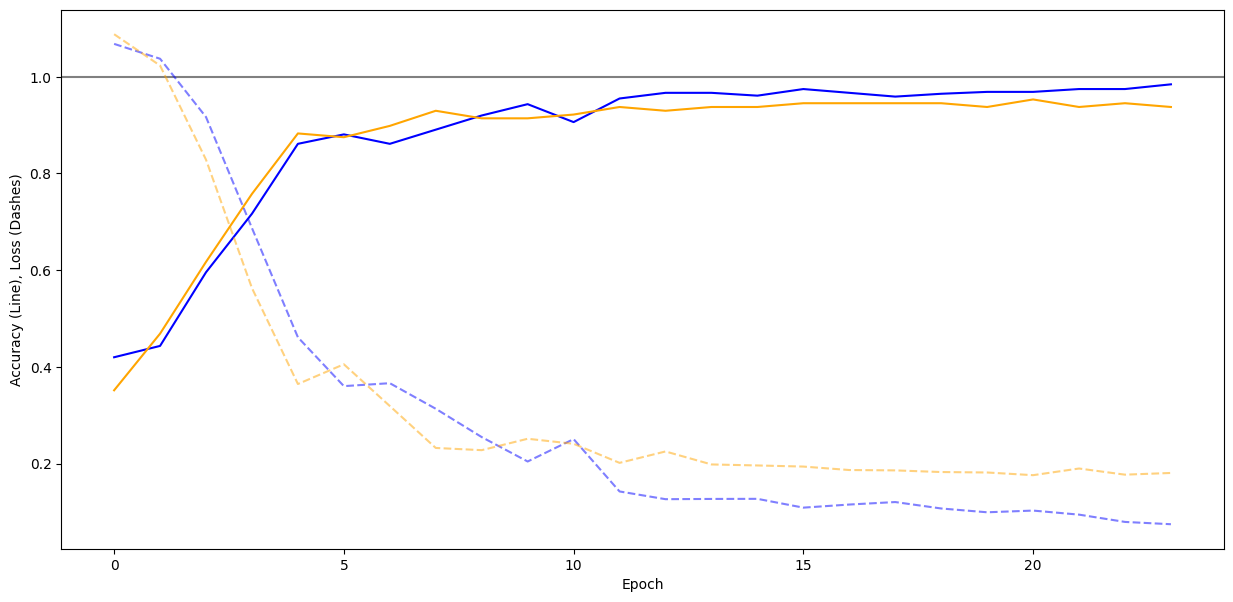

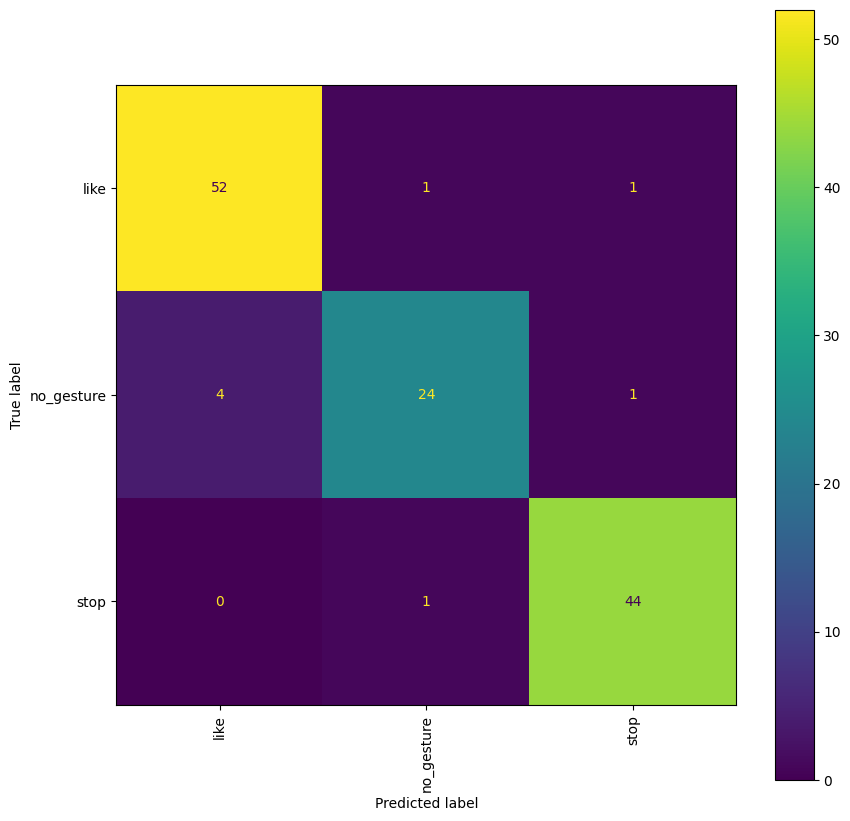

In [ ]:

# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'relu'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)



# let's have a look at our model
model.summary()



#Plotting the Progress
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)






#matrix
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

Version 2:
sigmoid


Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4100 - loss: 1.0969 - val_accuracy: 0.3516 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4423 - loss: 1.0391 - val_accuracy: 0.4688 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5672 - loss: 0.9716 - val_accuracy: 0.6172 - val_loss: 0.8285 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6807 - loss: 0.7436 - val_accuracy: 0.7578 - val_loss: 0.5629 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8407 - loss: 0.4834 - val_accuracy: 0.8828 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8722 - loss: 0.3758 - val_accuracy: 0.8750 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8611 - loss: 0.3765 - val_accuracy: 0.89

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_8 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_8               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
before [[0.13572873 0.00699487 0.8572764 ]
 [0.99081707 0.00579701 0.00338582]
 [0.9779629  0.00470654 0.01733048]
 [0.00319529 0.00415371 0.9926509 ]
 [0.99126583 0.005343   0.00339117]
 [0.9901372  0.00713286 0.00272991]
 [0.99146605 0.00398277 0.00455118]
 [0.01724527 0.9783328  0.00442194]
 [0.99148667 0.0045402  0.00397308]
 [0.99152136 0.00418503 0.00429362]
 [0.00454706 0.00728517 0.9881678 ]
 [0.00434893 0.9865975  0.00905367]
 [0.93843704 0.05560023 0.00596268]
 [0.00541897 0.00528445 0.9892966 ]
 [0.99067783 0.00636283 0.00295935]
 [0.02470031 0.12148481 0.85381484]
 [0.00614197 0.9903266  0.00353137]
 [0.00451864 0.00432173 0.9911596 ]
 [0.00506824 0.9870547  0.007877  ]
 [0.00244859 0.01155988 0.98599154]
 [0.50268173 0.38119388 0.11612443]
 [0.01631235 0.00445094 0.9792367 ]
 [0.63868135 0.3053004  0.05601829]
 [0.00425118 0.0034872  0.9922616 ]
 [0.98471284 0.00727684 0.00801037]
 [0.00713127 0.00299319 0.9898756 ]
 [0.00527723 0.0045

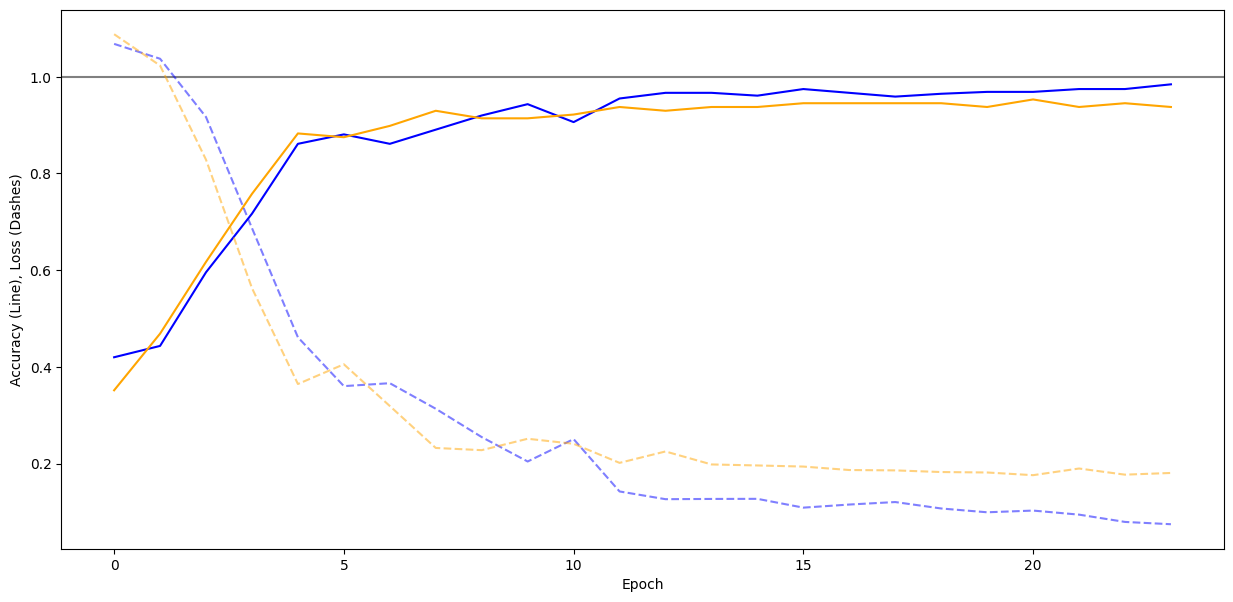

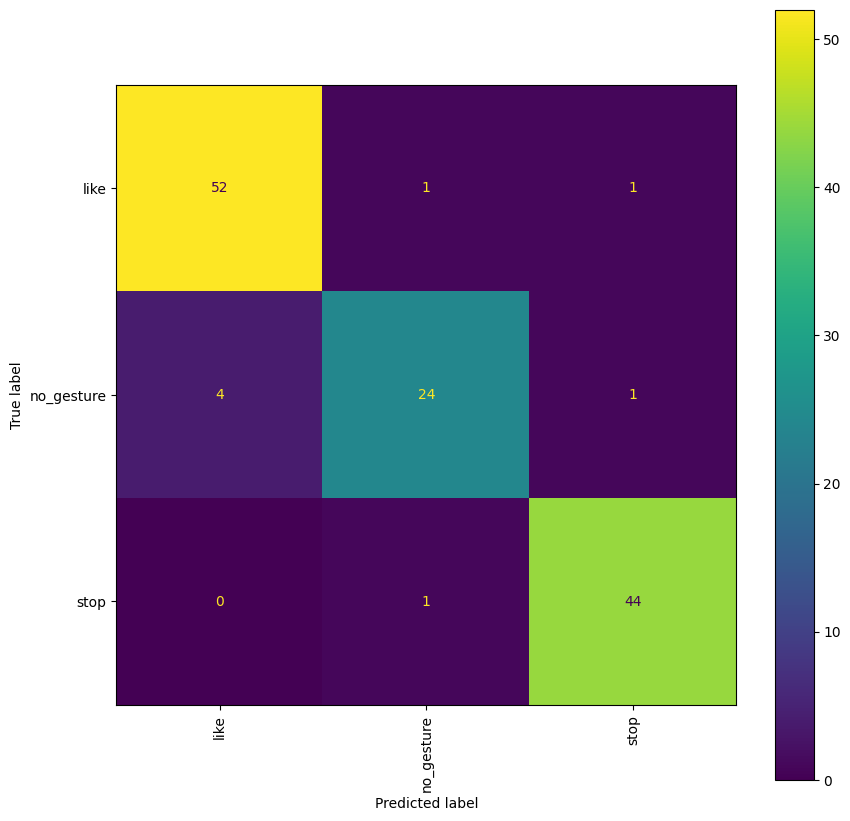

In [51]:

# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'sigmoid'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)



# let's have a look at our model
model.summary()



#Plotting the Progress
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)






#matrix
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

Version 3:
tanh


Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4513 - loss: 1.0376 - val_accuracy: 0.5859 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5956 - loss: 0.9146 - val_accuracy: 0.6484 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6660 - loss: 0.7368 - val_accuracy: 0.7734 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7423 - loss: 0.6355 - val_accuracy: 0.7656 - val_loss: 0.5216 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7988 - loss: 0.4897 - val_accuracy: 0.8359 - val_loss: 0.4486 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8455 - loss: 0.4205 - val_accuracy: 0.9062 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8547 - loss: 0.3973 - val_accuracy: 0.87

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
before [[5.56847006e-02 2.10242299e-03 9.42212880e-01]
 [9.99280035e-01 6.78519544e-04 4.14785936e-05]
 [9.86698747e-01 8.98535084e-03 4.31584846e-03]
 [5.87037066e-04 6.72021590e-04 9.98740971e-01]
 [9.99052584e-01 8.05155956e-04 1.42184494e-04]
 [9.98485744e-01 1.49698532e-03 1.72753898e-05]
 [9.99210954e-01 4.58585273e-04 3.30406474e-04]
 [3.38439941e-01 6.61095440e-01 4.64637968e-04]
 [9.99338329e-01 5.89946168e-04 7.17251314e-05]
 [9.98791158e-01 4.93394327e-04 7.15447357e-04]
 [6.71485614e-04 1.74420346e-02 9.81886387e-01]
 [1.83049578e-03 9.96632874e-01 1.53664860e-03]
 [3.10617357e-01 6.57426536e-01 3.19561251e-02]
 [7.26404926e-03 2.05145800e-03 9.90684509e-01]
 [9.99189198e-01 7.87660421e-04 2.30664118e-05]
 [6.61062682e-03 5.58718406e-02 9.37517524e-01]
 [1.18397560e-03 9.98150527e-01 6.65478699e-04]
 [4.84746008e-04 6.45121094e-04 9.98870075e-01]
 [4.27392544e-03 6.35245442e-01 3.60480577e-01]
 [2.73971964e-04 4.27287119e-03 9.95453119e

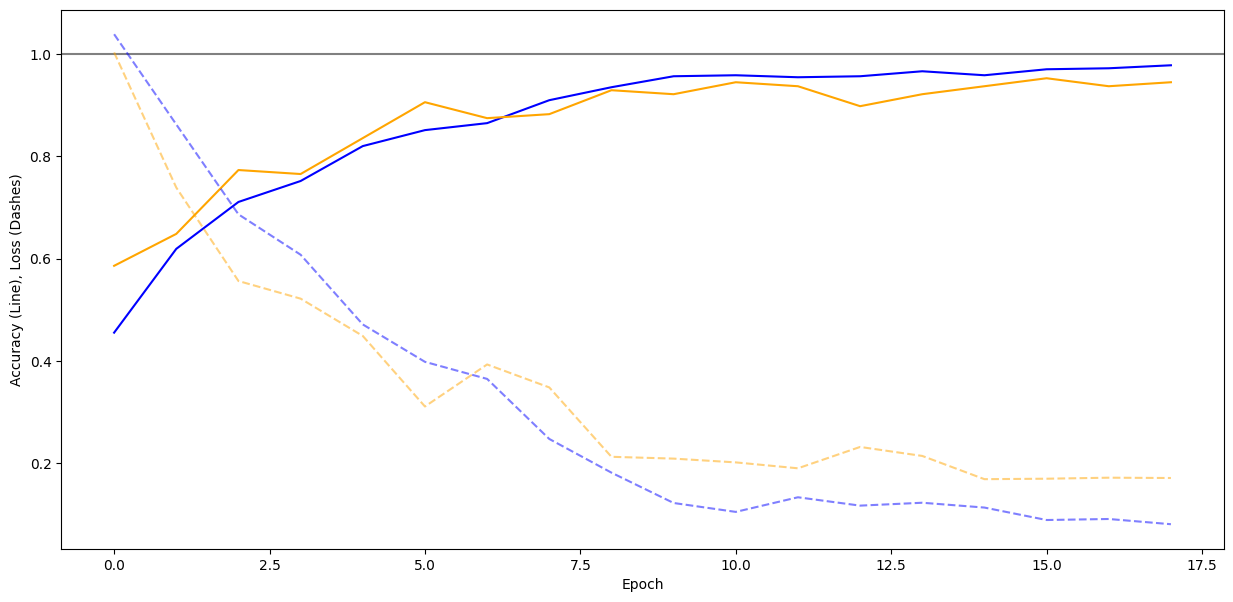

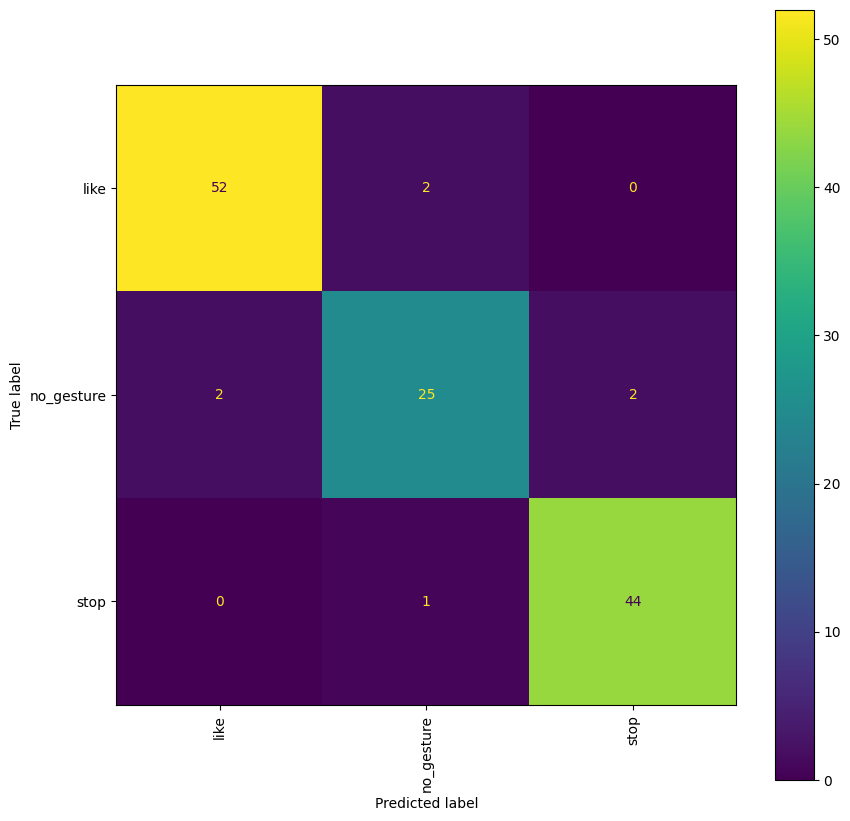

In [47]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'tanh'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)


# let's have a look at our model
model.summary()



#Plotting the Progress
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)






#matrix
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass


Version 4:
linear


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3995 - loss: 1.0796 - val_accuracy: 0.4609 - val_loss: 1.0214 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4800 - loss: 0.9789 - val_accuracy: 0.5625 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6943 - loss: 0.7438 - val_accuracy: 0.7969 - val_loss: 0.6085 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7631 - loss: 0.6023 - val_accuracy: 0.8125 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7844 - loss: 0.5185 - val_accuracy: 0.7891 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8106 - loss: 0.5088 - val_accuracy: 0.8594 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8594 - loss: 0.3891 - val_acc

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
before [[1.45337597e-01 5.51437843e-04 8.54110956e-01]
 [9.99996901e-01 2.52165887e-06 6.00369219e-07]
 [9.98112798e-01 1.51662563e-03 3.70672758e-04]
 [3.18740348e-07 1.62270771e-06 9.99997973e-01]
 [9.99983072e-01 3.85348949e-06 1.31687611e-05]
 [9.99999881e-01 1.23300197e-07 7.63979782e-11]
 [9.99989033e-01 6.48873424e-07 1.03975417e-05]
 [3.43760312e-01 5.90733588e-01 6.55061752e-02]
 [9.99999523e-01 5.04018544e-07 2.93023898e-08]
 [9.99994636e-01 1.87944022e-06 3.42183534e-06]
 [1.05391355e-05 5.93426230e-05 9.99930143e-01]
 [7.13039753e-06 9.99070883e-01 9.21980361e-04]
 [6.82135165e-01 3.16587061e-01 1.27779460e-03]
 [1.55475900e-05 2.15508160e-04 9.99769032e-01]
 [9.99999881e-01 1.24152237e-07 7.33718815e-12]
 [4.19313983e-06 9.00479645e-05 9.99905825e-01]
 [4.28782947e-08 9.99997020e-01 2.95307314e-06]
 [8.44951899e-07 3.26639747e-06 9.99995947e-01]
 [1.59560528e-04 9.99533296e-01 3.07149428e-04]
 [2.46312254e-07 1.34842082e-06 9.99998450e

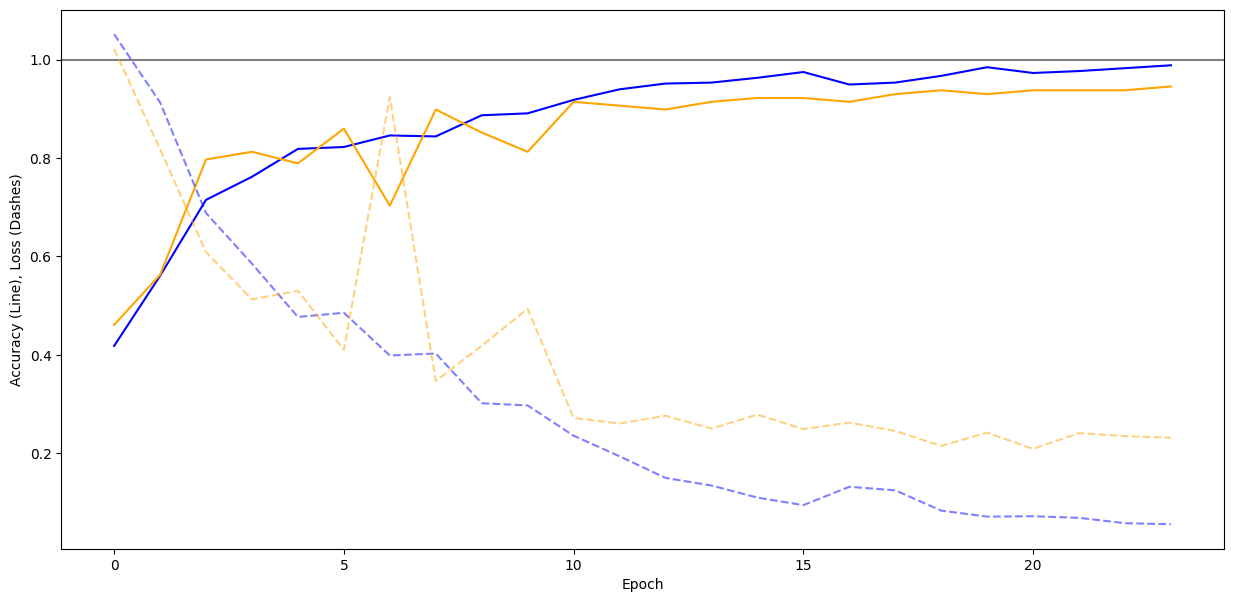

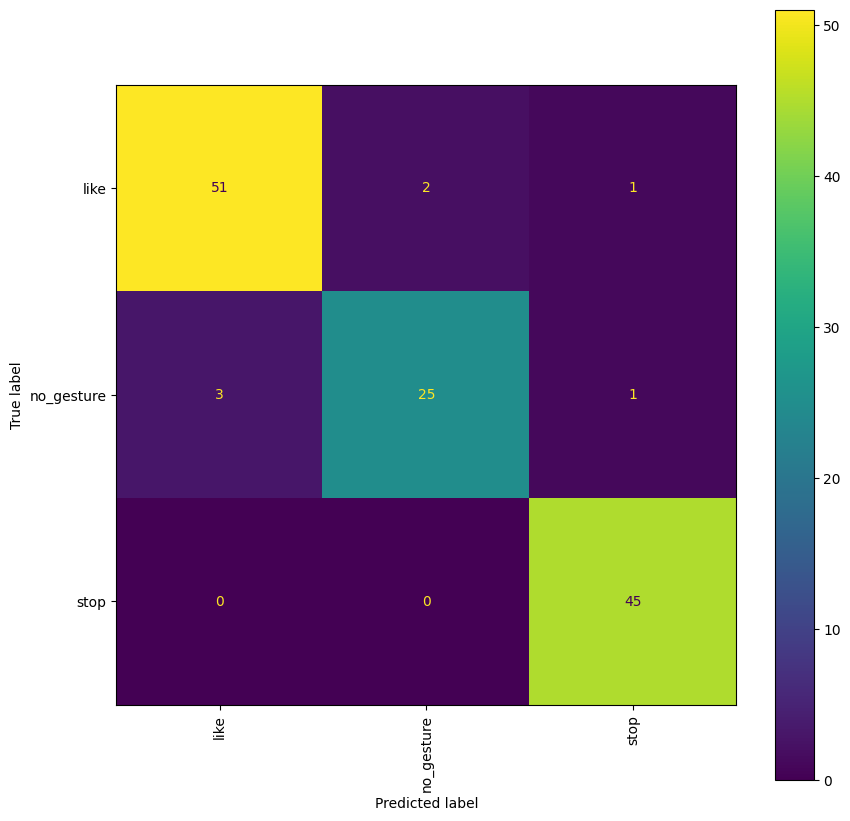

In [49]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'linear'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)


# let's have a look at our model
model.summary()



#Plotting the Progress
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)






#matrix
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass


Version 5:
softmax


Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3670 - loss: 1.0965 - val_accuracy: 0.4219 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4182 - loss: 1.0806 - val_accuracy: 0.4219 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3860 - loss: 1.0755 - val_accuracy: 0.4219 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3326 - loss: 1.0861 - val_accuracy: 0.4219 - val_loss: 1.0741 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3661 - loss: 1.0909 - val_accuracy: 0.3516 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4158 - loss: 1.0501 - val_accuracy: 0.3516 - val_loss: 1.0726 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3563 - loss: 1.0648 - val_accuracy: 0.35

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_7               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
before [[0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.22908686 0.3939178 ]
 [0.37699533 0.2290

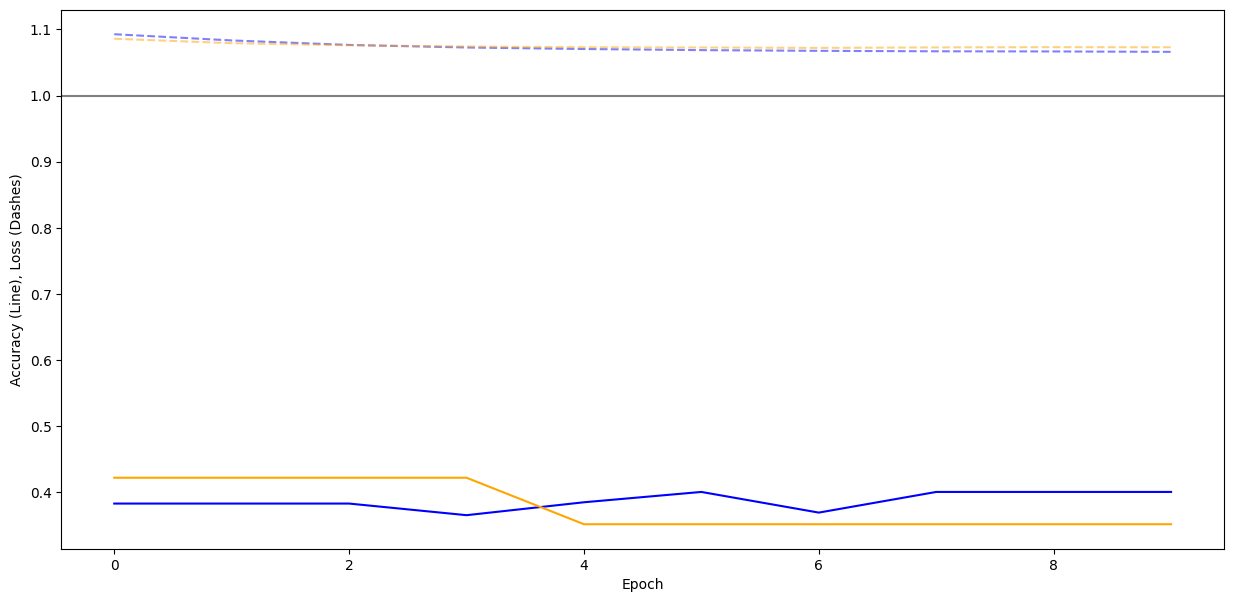

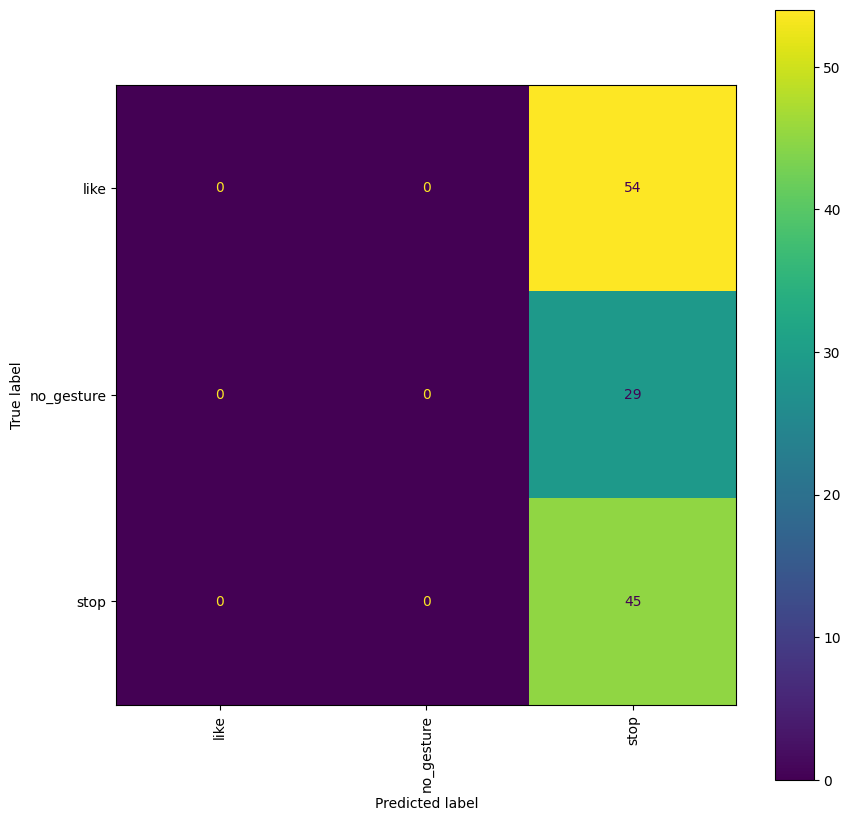

In [50]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'softmax'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)


# let's have a look at our model
model.summary()



#Plotting the Progress
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)






#matrix
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass


## let's test our model in action

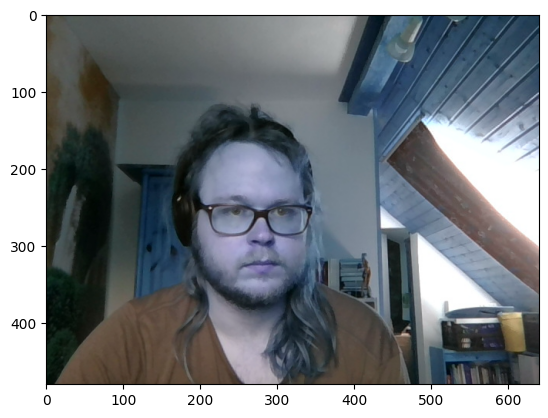

In [33]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

In [ ]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'relu'  # LeakyReLU
activation_hyperParam = 'sigmoid'
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation_hyperParam))

model.add(Dense(num_neurons, activation=activation_hyperParam))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


#training the model
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3730 - loss: 1.1040 - val_accuracy: 0.3516 - val_loss: 1.0814 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4141 - loss: 1.0628 - val_accuracy: 0.5000 - val_loss: 1.0282 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5685 - loss: 0.9763 - val_accuracy: 0.6094 - val_loss: 0.8600 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6445 - loss: 0.8094 - val_accuracy: 0.7344 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7721 - loss: 0.5800 - val_accuracy: 0.7031 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7770 - loss: 0.5667 - val_accuracy: 0.8516 - val_loss: 0.4156 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8234 - loss: 0.4488 - val_accuracy: 0.91

## manual cropping for demonstration purposes - you can do better!

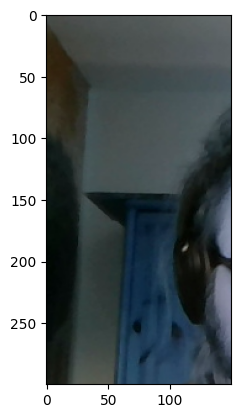

In [34]:
plt.imshow(frame[50:350, 60:210])

(64, 64, 3)

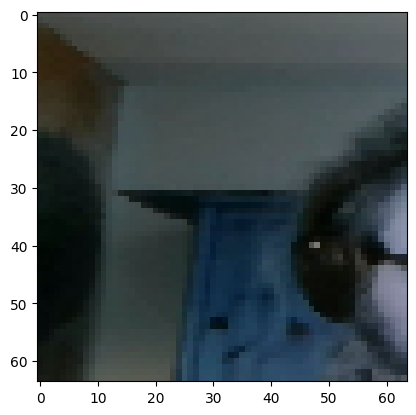

In [35]:
resized = cv2.resize(frame[50:350, 60:210], SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [36]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
no_gesture 1.0


(9, 9, 3, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057592403..0.07638963].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043955743..0.031217765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045296438..0.035044424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04840617..0.03250336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04011929..0.03207899].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04200771..0.030100534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Go

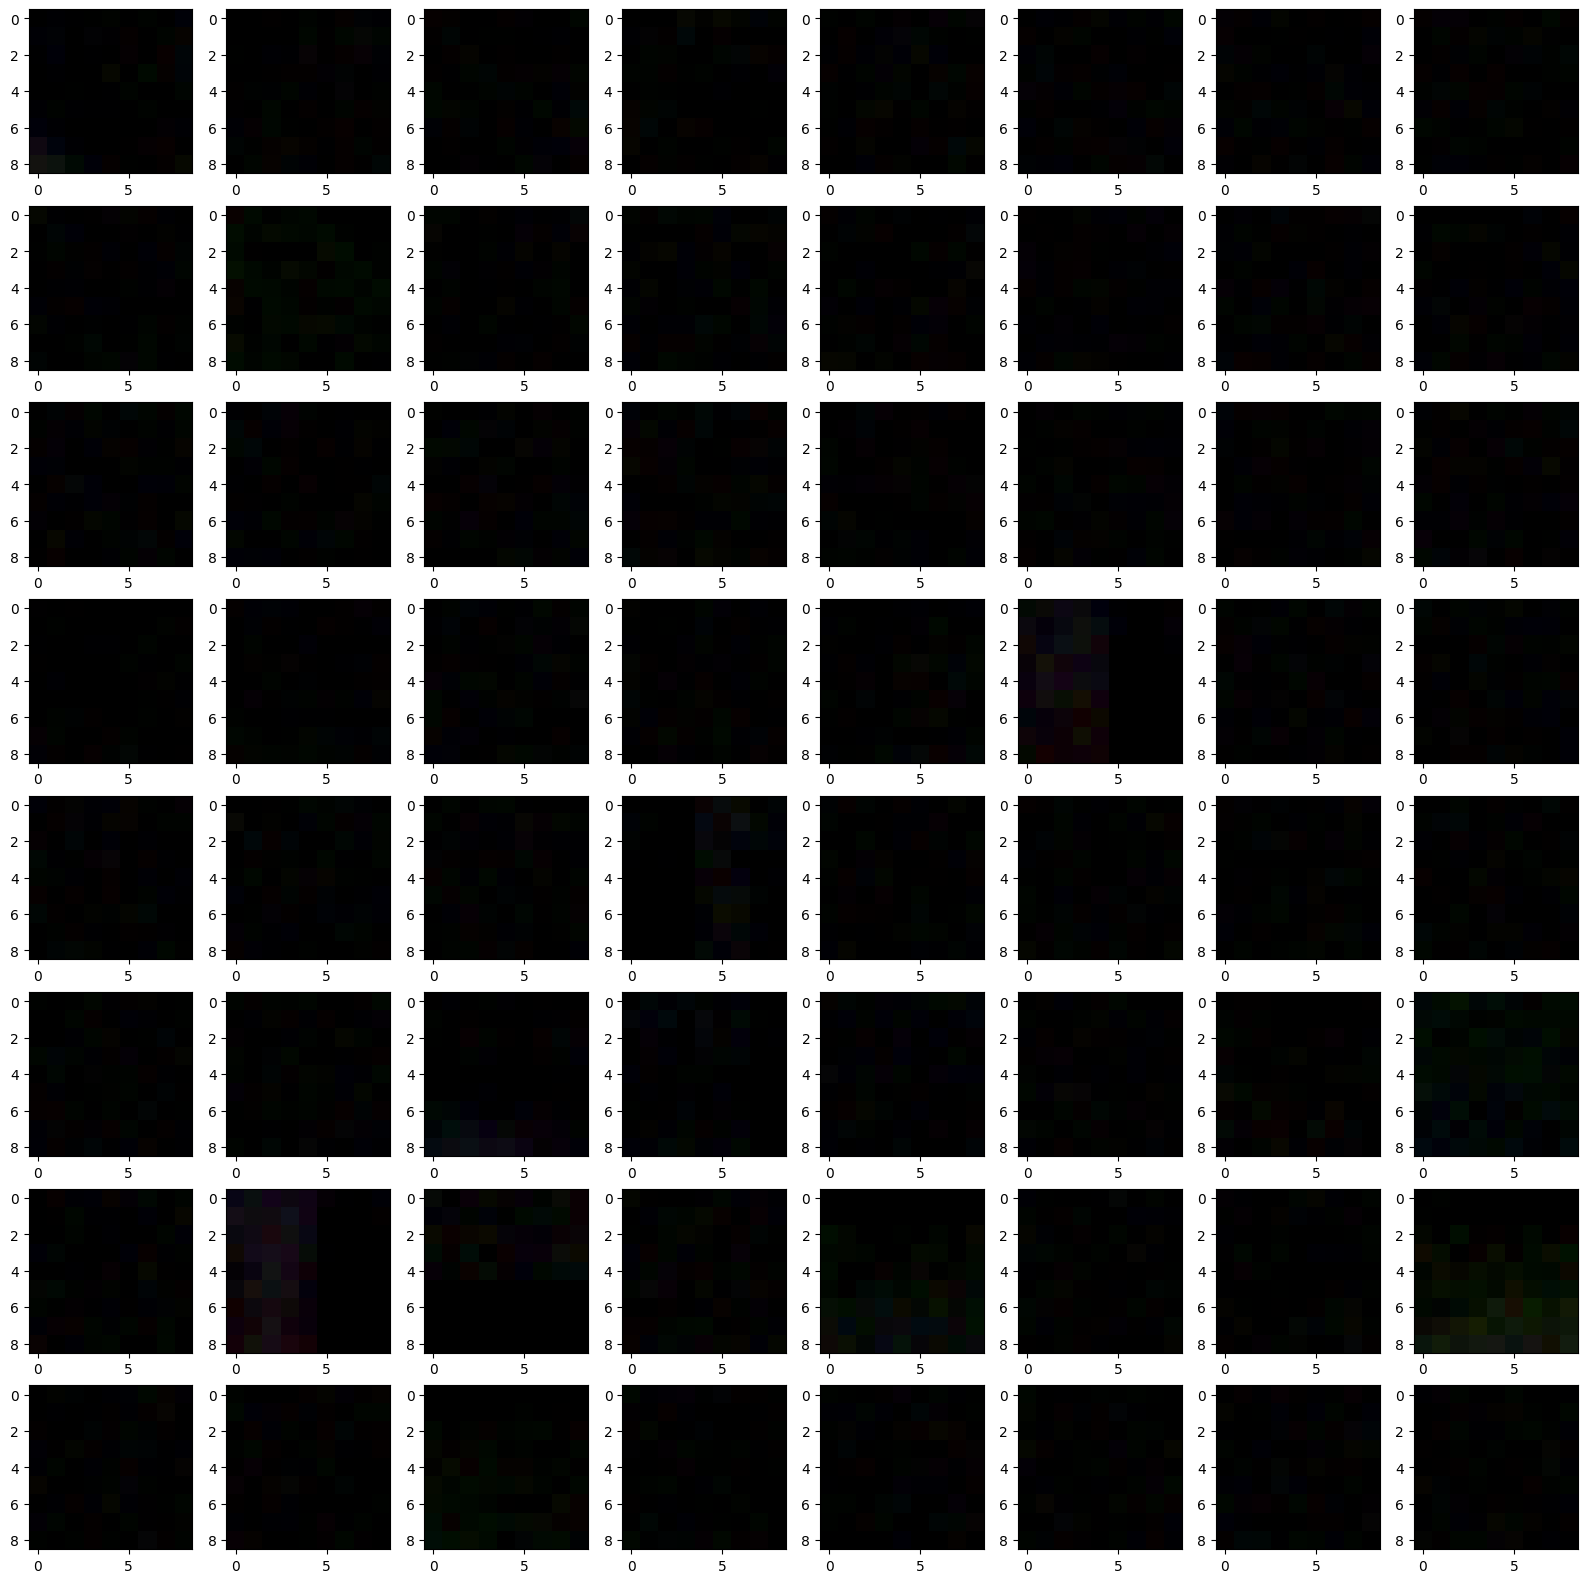

In [31]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

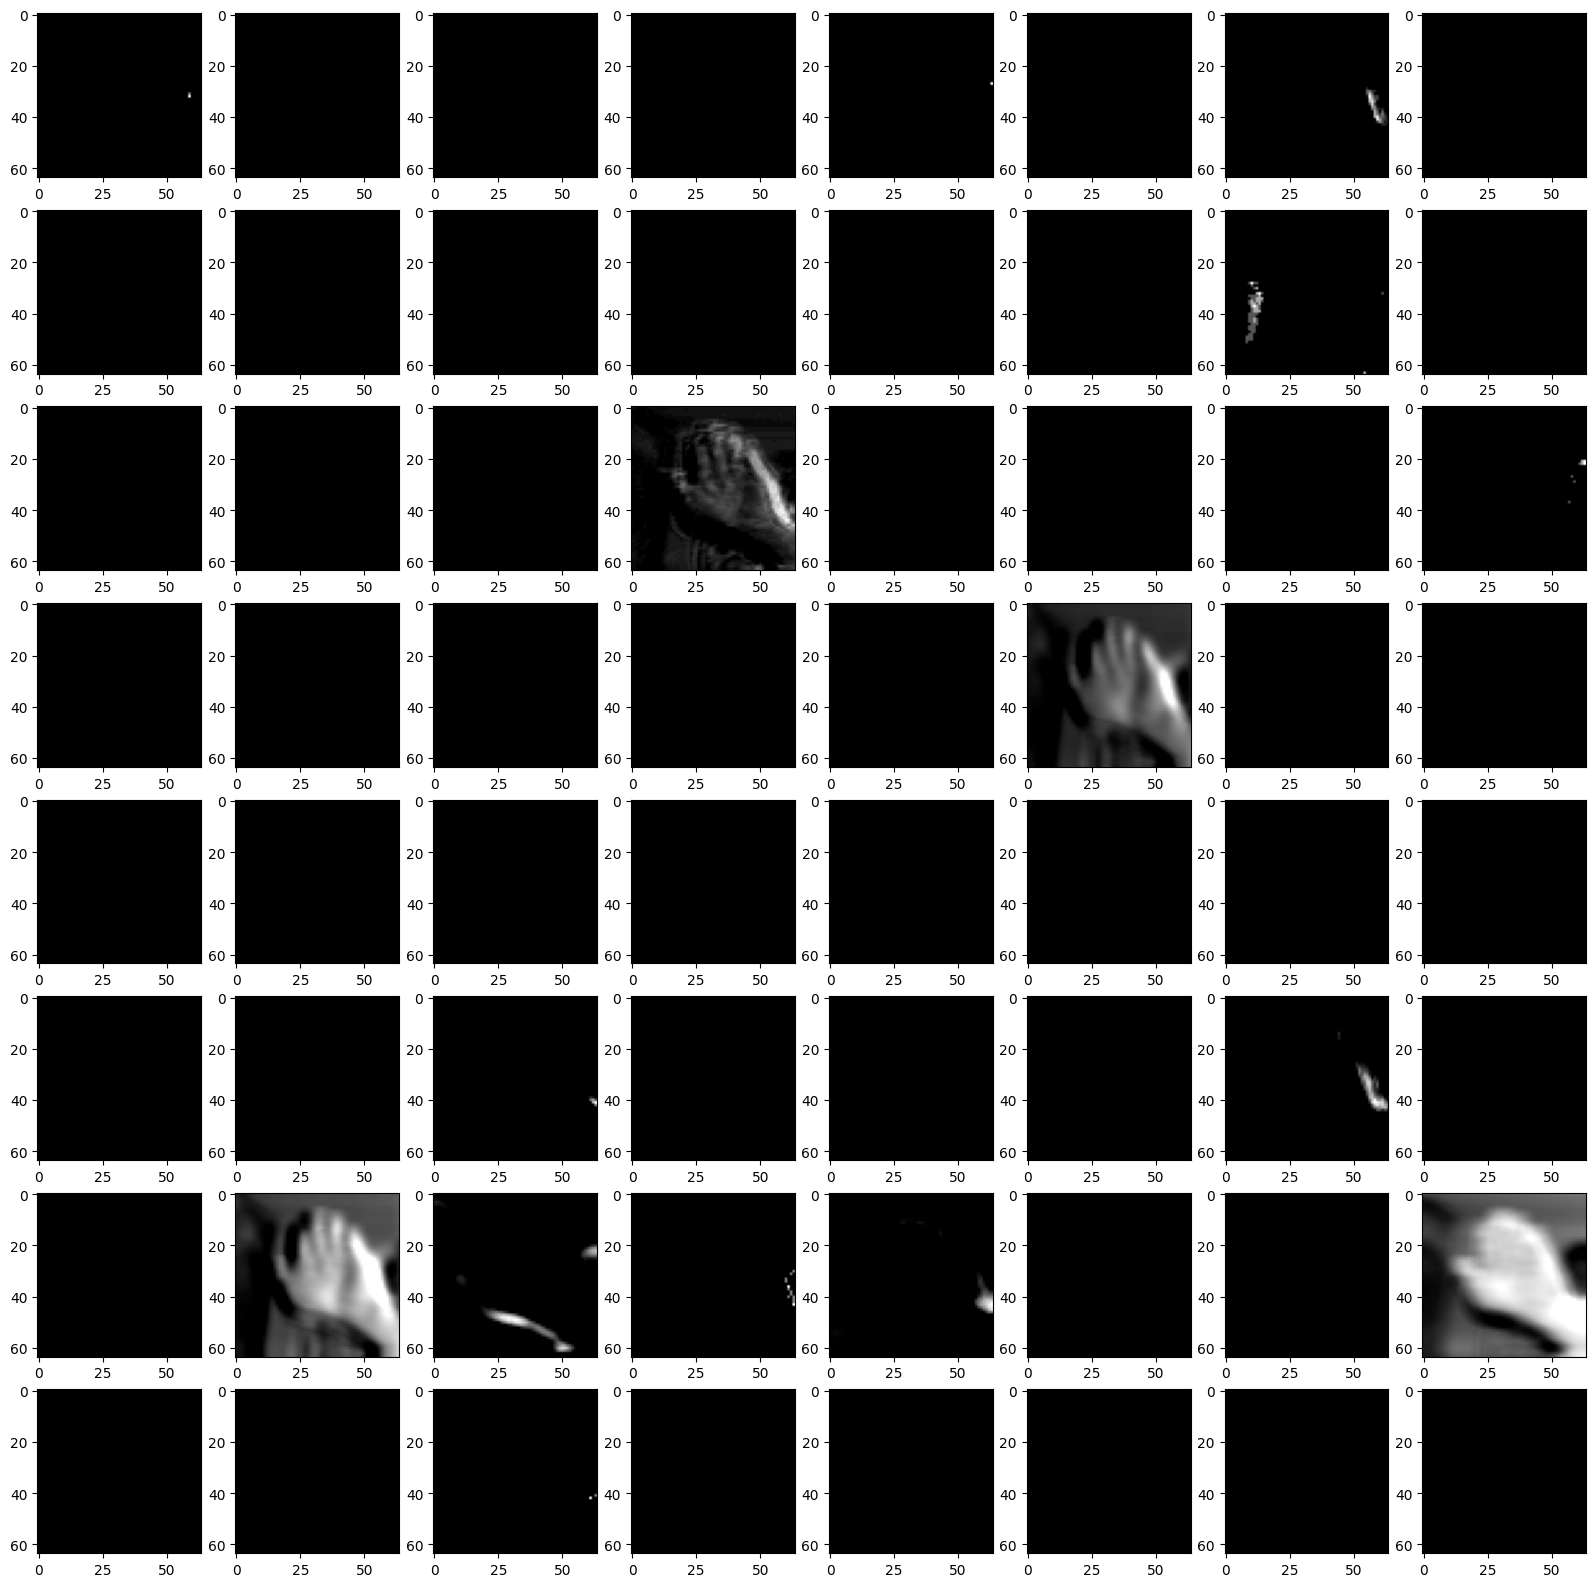

In [32]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass